In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from geopy.distance import geodesic
import sklearn.feature_selection
from sklearn.model_selection import train_test_split
import pickle
from sklearn import linear_model
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from time import time

#import warnings
#warnings.filterwarnings('ignore')

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#train_path = '/content/drive/My Drive/Colab Notebooks/train.csv'
train_path = 'train_orig.csv'

In [3]:
train = pd.read_csv(train_path, nrows=1_000_000) #we don't select all rows, since it is a big dataset
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [5]:
train.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

## Pre-processing (denoising data) and feature engineering

### Adding features

In [6]:
train['key'] = pd.to_datetime(train['key'])
train.dtypes

key                  datetime64[ns]
fare_amount                 float64
pickup_datetime              object
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

In [7]:
#add features related with datetime
train['weekday'] = train['key'].dt.dayofweek

train['year']=train['key'].dt.year
train['month']=train['key'].dt.month
train['day']=train['key'].dt.day
train['hour']=train['key'].dt.hour
#train['minute']=train['key'].dt.minute #needed?
#train['second']=train['key'].dt.second

### Drop outliers

In [8]:
#we drop already some clear errors in data set (NaN rows, and duplicates)

#check if there are some NaN values
train.columns[train.isna().any()].tolist()

['dropoff_longitude', 'dropoff_latitude']

In [9]:
#drop duplicates
train.drop_duplicates(keep = 'first', inplace = True)
train.shape[0]

1000000

In [10]:
#we drop these values given that the data set is quite big
#original rows: 1_000_000
train.dropna(inplace=True)
train.shape[0]

999990

In [11]:
train.describe()
#check the describe to see if their values make sense

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,weekday,year,month,day,hour
count,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000
mean,11.347953,-72.526699,39.929040,-72.527860,39.919954,1.684941,3.039870,2011.741103,6.267841,15.697996,13.509463
std,9.821790,12.057778,7.626087,11.324494,8.201418,1.323907,1.949966,1.860761,3.436230,8.682472,6.513855
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000,0.000000,2009.000000,1.000000,1.000000,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000,1.000000,2010.000000,3.000000,8.000000,9.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000,3.000000,2012.000000,6.000000,16.000000,14.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000,5.000000,2013.000000,9.000000,23.000000,19.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000,6.000000,2015.000000,12.000000,31.000000,23.000000


In [12]:
#we limit the coordinates to proper ranges to compute distances

#Latitudes range from -90 to 90. Longitudes range from -180 to 180.
train = train[ (train.pickup_longitude >= -180) & (train.pickup_longitude <= 180) & \
              (train.dropoff_longitude >= -180) & (train.dropoff_longitude <= 180) & \
              (train.pickup_latitude >= -90) & (train.pickup_latitude <= 90) & \
              (train.dropoff_latitude >= -90) & (train.dropoff_latitude <= 90) ]

In [13]:
#based on these descriptors, we can at first sight already remove some other outliers:
#2) passengers in a taxi, up to 6 (icnluding suvs) https://ride.guru/lounge/p/how-many-people-can-ride-in-a-cab 
#leave drives of 0 passengers in case documents are transported?
#3) fare has to be positive value, over 2.50$? (that seems to be the initial charge) https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page
#also fare now seems too high (500) and the variance is pretty hight too. so we cut the max fare now

#4) new york city actually has the following bounding box of coordinates (https://boundingbox.klokantech.com/)
#eastlimit_longitude=-73.700181
#southlimit_latitude =40.47739894
#westlimit_longitude=-74.25909
#northlimit_latitude=40.916178


#trying to use a bounding box slightly larger than the actual NY, so there is more flexibility for trips around airport
eastlimit_longitude=-73.664465
southlimit_latitude=40.477399
westlimit_longitude=-74.307165
northlimit_latitude=40.935154
                                                                                                               
train = train[ (train.pickup_longitude >= westlimit_longitude) & (train.pickup_longitude <= eastlimit_longitude) & \
              (train.dropoff_longitude >= westlimit_longitude) & (train.dropoff_longitude <= eastlimit_longitude) & \
              (train.pickup_latitude >= southlimit_latitude ) & (train.pickup_latitude <= northlimit_latitude) & \
              (train.dropoff_latitude >= southlimit_latitude) & (train.dropoff_latitude <= northlimit_latitude) ]                                                                              

train = train[(train.passenger_count<= 6) & \
              (train.fare_amount > 2.50)  ]
   


In [14]:
#there are some flat rates on trips from/to some of the airports in NY (JFK, LaGuardia, Newark) so we add features of
#distances from/to these airports
# coordinates from https://get-direction.com
jfk_latitude = 40.644538879
jfk_longitude = -73.795356750
laguardia_latitude = 40.774009705
laguardia_longitude =-73.872497559
newark_latitude = 40.692878723
newark_longitude = -74.185447693

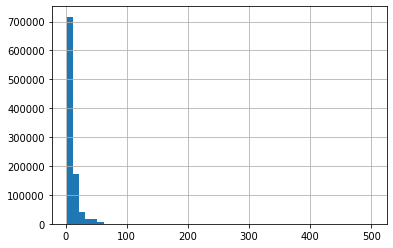

In [15]:
train.fare_amount.hist(bins=50)

In [16]:
train = train[ (train.fare_amount < 100)]

### Adding more features

In [17]:
#Absolute differences between longitudes and between latitudes
train ['abs_diff_longitude']=np.abs(train.pickup_longitude-train.dropoff_longitude)
train ['abs_diff_latitude']=np.abs(train.pickup_latitude-train.dropoff_latitude)

In [18]:
#add distance

#Instead of doing Harvestine distance (that assumes Earth is a sphere), here Vincenty distance is used,
#which employs more accurate ellipsoidal models

# (latitude, longitude) reminder
#train ['distance'] = train.apply(lambda x: geodesic((x['pickup_latitude'], x['pickup_longitude']), (x['dropoff_latitude'], x['dropoff_longitude'])).kilometers, axis = 1)
#train ['distance'] = train.drop(['key'],axis=1, inplace=False).apply(lambda x: mpu.haversine_distance((x['pickup_latitude'], x['pickup_longitude']), (x['dropoff_latitude'], x['dropoff_longitude'])))

def haversine_distance(df_pickup_lat, df_pickup_long,df_dropoff_lat,df_dropoff_long):

    #6367 earth radius
    distance_col = 6367 * 2 * np.arcsin(np.sqrt(np.sin((np.radians(df_pickup_lat) /
                                                        - np.radians(df_dropoff_lat))/2)**2 /
                                                + np.cos(np.radians(df_dropoff_lat))*np.cos(np.radians(df_pickup_lat))*np.sin((np.radians(df_pickup_long) - np.radians(df_dropoff_long))/2)**2))
    return distance_col
 
    


In [19]:
train ['distance'] = haversine_distance(train['pickup_latitude'],train['pickup_longitude'],train['dropoff_latitude'],train['dropoff_longitude'])

In [20]:
train.isna().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count       0
weekday               0
year                  0
month                 0
day                   0
hour                  0
abs_diff_longitude    0
abs_diff_latitude     0
distance              0
dtype: int64

In [21]:
train.dropna(inplace=True)
train.shape[0]

974388

In [22]:
train['distance']

0         0.143919
1         1.957430
2         0.453133
3         0.236298
4         0.609337
            ...   
999995    0.931414
999996    0.000000
999997    0.797626
999998    0.185713
999999    0.382766
Name: distance, Length: 974388, dtype: float64

In [23]:
train ['pickup_distance_jfk'] = haversine_distance(train['pickup_latitude'],train['pickup_longitude'],jfk_latitude, jfk_longitude)

In [24]:
train ['pickup_distance_laguardia'] = haversine_distance(train['pickup_latitude'],train['pickup_longitude'],laguardia_latitude, laguardia_longitude)

In [25]:
train ['pickup_distance_newark'] = haversine_distance(train['pickup_latitude'],train['pickup_longitude'],newark_latitude, newark_longitude)


In [26]:
train ['dropoff_distance_jfk'] = haversine_distance(train['dropoff_latitude'],train['dropoff_longitude'],jfk_latitude, jfk_longitude)


In [27]:
train ['dropoff_distance_laguardia'] = haversine_distance(train['dropoff_latitude'],train['dropoff_longitude'],laguardia_latitude, laguardia_longitude)


In [28]:
train ['dropoff_distance_newark'] = haversine_distance(train['dropoff_latitude'],train['dropoff_longitude'],newark_latitude, newark_longitude)


In [29]:
train.isna().sum()

key                           0
fare_amount                   0
pickup_datetime               0
pickup_longitude              0
pickup_latitude               0
dropoff_longitude             0
dropoff_latitude              0
passenger_count               0
weekday                       0
year                          0
month                         0
day                           0
hour                          0
abs_diff_longitude            0
abs_diff_latitude             0
distance                      0
pickup_distance_jfk           0
pickup_distance_laguardia     0
pickup_distance_newark        0
dropoff_distance_jfk          0
dropoff_distance_laguardia    0
dropoff_distance_newark       0
dtype: int64

In [30]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,weekday,year,month,day,hour,abs_diff_longitude,abs_diff_latitude,distance,pickup_distance_jfk,pickup_distance_laguardia,pickup_distance_newark,dropoff_distance_jfk,dropoff_distance_laguardia,dropoff_distance_newark
count,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000,974388.000000
mean,11.302589,-73.975547,40.750897,-73.974596,40.751250,1.686087,3.039591,2011.740771,6.269020,15.691382,13.512700,0.022652,0.021243,1.206739,9.633673,5.648909,11.192924,9.579942,5.562777,11.243857
std,9.309636,0.034337,0.026812,0.033876,0.030721,1.308440,1.949780,1.862689,3.438059,8.683095,6.510658,0.033406,0.022709,1.779557,1.731019,1.244893,1.826411,1.721616,1.368310,1.802738
min,2.510000,-74.299640,40.481047,-74.300537,40.479537,0.000000,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.001585,0.000077,0.006963,0.000280,0.000023,0.009872
25%,6.000000,-73.992279,40.736600,-73.991573,40.735617,1.000000,1.000000,2010.000000,3.000000,8.000000,9.000000,0.006186,0.006995,0.329575,9.235921,5.110038,10.298683,9.077374,4.965867,10.336614
50%,8.500000,-73.982097,40.753415,-73.980610,40.753873,1.000000,3.000000,2012.000000,6.000000,16.000000,14.000000,0.012740,0.014210,0.678752,9.966250,5.838177,10.845001,9.885530,5.760235,10.923105
75%,12.500000,-73.968400,40.767557,-73.965427,40.768405,2.000000,5.000000,2013.000000,9.000000,23.000000,19.000000,0.023942,0.027212,1.275547,10.506294,6.378518,11.576394,10.469044,6.342576,11.734702
max,99.750000,-73.665171,40.932743,-73.664619,40.935133,6.000000,6.000000,2015.000000,12.000000,31.000000,23.000000,0.515475,0.312945,27.452157,26.815742,22.669672,27.795514,26.863091,22.716982,27.781329


In [31]:
train.describe().loc[['min','max']]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,weekday,year,month,day,hour,abs_diff_longitude,abs_diff_latitude,distance,pickup_distance_jfk,pickup_distance_laguardia,pickup_distance_newark,dropoff_distance_jfk,dropoff_distance_laguardia,dropoff_distance_newark
min,2.51,-74.299640,40.481047,-74.300537,40.479537,0.0,0.0,2009.0,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.001585,0.000077,0.006963,0.000280,0.000023,0.009872
max,99.75,-73.665171,40.932743,-73.664619,40.935133,6.0,6.0,2015.0,12.0,31.0,23.0,0.515475,0.312945,27.452157,26.815742,22.669672,27.795514,26.863091,22.716982,27.781329


In [32]:
#related with distances, we remove the following cases:
#A) distance is 0, and the coordinates of pick up and dropoff are different (so no possible then for round trip
# or for the taxi waiting the customer)
#B) distance is not 0, but coordinates of pick up and dropoff are same
idx_distCaseA = train.index[ (train.distance == 0) &  ( (train.pickup_latitude != train.dropoff_latitude ) | \
                                                         (train.pickup_longitude != train.dropoff_longitude)) ]

idx_distCaseB = train.index[ (train.distance != 0) &  ( (train.pickup_latitude == train.dropoff_latitude ) & \
                                                         (train.pickup_longitude == train.dropoff_longitude)) ]


In [33]:
#idx_distCaseB and idx_distCaseA seems empty, but there are distances of 0 (10156 rows) 
#so those have same pickup and dropoff coordinates 
idx_distCaseB

Int64Index([], dtype='int64')

In [34]:
#actually keeping the other cases of distances = 0 seem to decrease the performance, so they are removed

#removed any row with distance equal to 0:
train = train[ (train.distance > 0)]

In [35]:
#log transform for distance helps
train['distance_log'] = train['distance'].transform(lambda x: np.log(x+sys.float_info.epsilon))
train['abs_diff_latitude_log'] = train['abs_diff_latitude'].transform(lambda x: np.log(x+sys.float_info.epsilon))
train['abs_diff_longitude_log'] = train['abs_diff_longitude'].transform(lambda x: np.log(x+sys.float_info.epsilon))

train.shape

(964806, 25)

## Data visualization (exploratory analysis)

In [ ]:
#check distributions of all the features
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
train.hist(ax = ax, bins=50)


In [ ]:
corr_pearson = train.corr(method='pearson')
mask = np.zeros_like(corr_pearson, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

In [ ]:
fig4, ax4 = plt.subplots(figsize=(16, 10))
sns.heatmap(corr_pearson, mask=mask, cmap='RdBu_r', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},vmin=-1)

In [ ]:
#visualizer = FeatureCorrelation( method='mutual_info-classification', feature_names=train_out.columns, sort=True)
X = train.drop(['fare_amount','key','pickup_datetime'],axis=1, inplace=False).to_numpy()
Y = train.fare_amount.to_numpy()
#lab_enc = sklearn.preprocessing.LabelEncoder()
#Y_encoded = lab_enc.fit_transform(Y)

#mutual information has too expensive computationally to run for all data, so we just take 
X = X[1:100000,:]
Y = Y[1:100000]

feature_MIscores = sklearn.feature_selection.mutual_info_regression(X, Y)

In [ ]:
feature_MIscores.shape

#plot also the fare vs the date (year), and maybe check as hypothesis if there is a positive correlation between year and fare

In [ ]:
feats_labels = train.drop(['fare_amount','key','pickup_datetime'],axis=1, inplace=False).columns
#print(feats_labels)
index = np.arange(len(feats_labels))
plt.figure(figsize=(10,10))
plt.barh(index, feature_MIscores)
plt.xlabel('mutual information score', fontsize=20)
plt.yticks(index, feats_labels, fontsize=10, rotation=30)

In [ ]:
#sns.pairplot(train, y_vars=['fare_amount'], x_vars=['distance', 'distance_log', 'hour','day','month','year','weekday','passenger_count','dropoff_latitude','dropoff_longitude','pickup_latitude','pickup_longitude'])

In [ ]:
sns.scatterplot(x="distance", y="fare_amount", data=train)

In [ ]:
#there is also a kind of straight line, that can be explained by the flat rates used for taxi rides from airport
 #"Taxis at JFK Airport charge a flat fare of $52 for trips between the airport and Manhattan." 
#https://www.jfkairport.com/to-from-airport/taxi-car-and-van-service
sns.scatterplot(x="distance_log", y="fare_amount", data=train)

In [ ]:
#using hex bins because regular scatter plot does not work (too many points)
sns.jointplot(x="distance", y="fare_amount", data=train, kind='reg',joint_kws={'line_kws':{'color':'cyan'}})

In [ ]:
#using hex bins because regular scatter plot does not work (too many points)
#easier to see with dostance_log since the scale is shrunk
sns.jointplot(x="distance", y="fare_amount", data=train, kind='hex')

In [ ]:
#TODO: maybe also plot histograms grouping by day, or by hour, to see what times are more common, and see if the fair is similar for 

In [ ]:
#TODO:maybe a heat map of the fares would be interesting, doing a geomap, maybe use plotly?

In [ ]:
#TODO: maybe employ clustering to get some extra information of the data, like outliers? 

## Split of training data (train + validation)

In [36]:
train2, val = train_test_split(train, test_size=0.3)

In [37]:
train.shape

(964806, 25)

In [38]:
train2.shape

(675364, 25)

In [39]:
train.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'weekday', 'year', 'month', 'day', 'hour',
       'abs_diff_longitude', 'abs_diff_latitude', 'distance',
       'pickup_distance_jfk', 'pickup_distance_laguardia',
       'pickup_distance_newark', 'dropoff_distance_jfk',
       'dropoff_distance_laguardia', 'dropoff_distance_newark', 'distance_log',
       'abs_diff_latitude_log', 'abs_diff_longitude_log'],
      dtype='object')

In [40]:
val.shape

(289442, 25)

## Modeling 
### (Comparison of several regression models, plus a dummy model as baseline)

In [41]:
features_set1=['year','distance','pickup_distance_jfk','pickup_distance_laguardia',\
                  'dropoff_distance_jfk','dropoff_distance_laguardia','abs_diff_latitude','abs_diff_longitude','dropoff_distance_newark','pickup_distance_newark']

X_train = train2[features_set1]
y_train = train2[['fare_amount']]

X_val = val[features_set1]
y_val = val[['fare_amount']]

### Dummy model

In [42]:
dummy_regr = DummyRegressor(strategy="mean")
t0_dummy=time()
dummy_regr.fit(X_train, y_train)
print("Dummy model regression, training time:" + str(round(time()-t0_dummy, 3)) + "s")
print(dummy_regr)


Dummy model regression, training time:0.003s
DummyRegressor(constant=None, quantile=None, strategy='mean')


In [43]:
y_valPred_dummy = dummy_regr.predict(X_val)
y_trainPred_dummy = dummy_regr.predict(X_train)

In [44]:
#R2 is the proportion of the variance in the dependent variable that is predictable from the independent
#variable(s).

r2_val_dummy = r2_score(y_val, y_valPred_dummy)
r2_train_dummy = r2_score(y_train, y_trainPred_dummy)

print('Dummy model- training, R2:' + str(r2_train_dummy))
print('Dummy model- validation, R2:' + str(r2_val_dummy))


Dummy model- training, R2:0.0
Dummy model- validation, R2:-5.565194197032497e-06


In [45]:
mse_val_dummy = mean_squared_error(y_val, y_valPred_dummy)
mse_train_dummy = mean_squared_error(y_train, y_trainPred_dummy)

print('Dummy model - training, MSE:' + str(mse_train_dummy))
print('Dummy model - validation, MSE:' + str(mse_val_dummy))

Dummy model - training, MSE:86.10450422385198
Dummy model - validation, MSE:85.90208518453798


### Linear regression

In [46]:
scaler = StandardScaler()
scaler.fit(X_train)

#use same scaler for both, based on X_train data
X_trainNorm = scaler.transform(X_train)
X_valNorm = scaler.transform(X_val)

In [47]:
# create linear regression model
linRegr = linear_model.LinearRegression()
print(linRegr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


In [48]:
# train the model with training data

t0_linR=time()
linRegr.fit(X_trainNorm, y_train)
print("Linear regression, training time:" + str(round(time()-t0_linR, 3)) + "s")
print(linRegr)

Linear regression, training time:0.197s
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


In [49]:
y_valPred_linReg = linRegr.predict(X_valNorm) #to check validation error measures
y_trainPred_linReg = linRegr.predict(X_trainNorm) #to check training error measures

In [50]:
r2_val_linReg = r2_score(y_val, y_valPred_linReg)
r2_train_linReg = r2_score(y_train, y_trainPred_linReg)

print('Linear regression - training, R2:' + str(r2_train_linReg))
print('Linear regression - validation, R2:' + str(r2_val_linReg))


Linear regression - training, R2:0.791628526092792
Linear regression - validation, R2:0.7911864687215577


In [51]:
mse_val_linReg = mean_squared_error(y_val, y_valPred_linReg)
mse_train_linReg = mean_squared_error(y_train, y_trainPred_linReg)

print('Linear regression - training, MSE:' + str(mse_train_linReg))
print('Linear regression - validation, MSE:' + str(mse_val_linReg))


Linear regression - training, MSE:17.941722455173455
Linear regression - validation, MSE:17.93741792635078


### Linear regression with Lasso regularization (i.e. feature selection)

In [52]:
train2.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'weekday', 'year', 'month', 'day', 'hour',
       'abs_diff_longitude', 'abs_diff_latitude', 'distance',
       'pickup_distance_jfk', 'pickup_distance_laguardia',
       'pickup_distance_newark', 'dropoff_distance_jfk',
       'dropoff_distance_laguardia', 'dropoff_distance_newark', 'distance_log',
       'abs_diff_latitude_log', 'abs_diff_longitude_log'],
      dtype='object')

In [53]:
X_train_lasso = train2.drop(['fare_amount','key','pickup_datetime','distance_log','abs_diff_latitude_log','abs_diff_longitude_log'],axis=1, inplace=False)
y_train_lasso = train2[['fare_amount']]

X_val_lasso = val.drop(['fare_amount','key','pickup_datetime','distance_log','abs_diff_latitude_log','abs_diff_longitude_log'],axis=1, inplace=False)
y_val_lasso = val[['fare_amount']]

In [54]:
X_train_lasso.shape

(675364, 19)

In [55]:
y_train_lasso.shape

(675364, 1)

In [56]:
scaler_lasso = StandardScaler()
scaler_lasso.fit(X_train_lasso)

#use same scaler for both, based on X_train_lasso data
X_trainLassoNorm = scaler_lasso.transform(X_train_lasso)
X_valLassoNorm = scaler_lasso.transform(X_val_lasso)

In [57]:
lassoReg = linear_model.LassoCV(cv=5)
t0_linRLasso=time()
lassoReg.fit(X_trainLassoNorm, y_train_lasso.values.ravel())
print("Linear regression with Lasso reg., training time:" + str(round(time()-t0_linRLasso, 3)) + "s")
print(lassoReg)

Linear regression with Lasso reg., training time:14.872s
LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)


In [58]:
y_valPred_lassoReg = lassoReg.predict(X_valLassoNorm)
y_trainPred_lassoReg = lassoReg.predict(X_trainLassoNorm)

In [59]:
r2_val_lassoReg = r2_score(y_val_lasso, y_valPred_lassoReg)
r2_train_lassoReg = r2_score(y_train_lasso, y_trainPred_lassoReg)

print('Linear regression with Lasso reg. - training, R2:' + str(r2_train_lassoReg))
print('Linear regression with Lasso reg. - validation, R2:' + str(r2_val_lassoReg))

Linear regression with Lasso reg. - training, R2:0.7936787493537408
Linear regression with Lasso reg. - validation, R2:0.79293902111166


In [60]:
mse_val_lassoReg = mean_squared_error(y_val_lasso, y_valPred_lassoReg)
mse_train_lassoReg = mean_squared_error(y_train_lasso, y_trainPred_lassoReg)

print('Linear regression with Lasso reg. - training, MSE:' + str(mse_train_lassoReg))
print('Linear regression with Lasso reg. - validation, MSE:' + str(mse_val_lassoReg))

Linear regression with Lasso reg. - training, MSE:17.765188997741248
Linear regression with Lasso reg. - validation, MSE:17.786870859469506


In [61]:
#TODO: include a plotbar showing the weights obtained

### Random forest regression

Decision trees can deal with non-linearity relationships between independent variables and the dependent variable (fare_amount), unlike linear regressors.

In [62]:
randFor = RandomForestRegressor(n_estimators=10) #current default, future is 100, but it is too much computation

#decisions trees don't need normalized data since they don't assume any distribution

t0_randFor=time()
randFor.fit(X_train_lasso, y_train_lasso.values.ravel())
print("Random forest regression, training time:" + str(round(time()-t0_randFor, 3)) + "s")
print(randFor)

Random forest regression, training time:160.652s
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


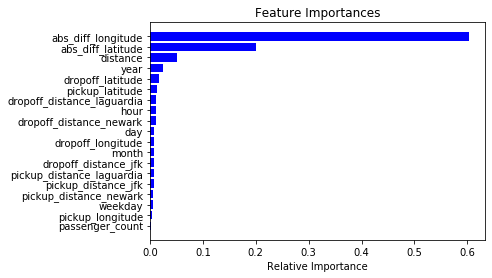

In [63]:
importances = randFor.feature_importances_

indices = np.argsort(importances)

features =  X_train_lasso.columns

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


#Avenues generally run north and south in NY.
# all streets run east and west
#https://becomeanewyorker.com/streets-and-avenues-there-is-a-differenc/
#it may be that taxis go mainly through avenues, and that is why longitude affects so much

In [64]:
y_valPred_randFor = randFor.predict(X_val_lasso)
y_trainPred_randFor = randFor.predict(X_train_lasso)

In [65]:
r2_val_randFor = r2_score(y_val_lasso, y_valPred_randFor)
r2_train_randFor = r2_score(y_train_lasso, y_trainPred_randFor)

print('Random forest regression - training, R2:' + str(r2_train_randFor))
print('Random forest regression - validation, R2:' + str(r2_val_randFor))

Random forest regression - training, R2:0.9770583576564876
Random forest regression - validation, R2:0.8726307115366575


In [66]:
mse_val_randFor = mean_squared_error(y_val_lasso, y_valPred_randFor)
mse_train_randFor = mean_squared_error(y_train_lasso, y_trainPred_randFor)

print('Random forest regression - training, MSE:' + str(mse_train_randFor))
print('Random forest regression - validation, MSE:' + str(mse_val_randFor))

Random forest regression - training, MSE:1.9753787400690597
Random forest regression - validation, MSE:10.941226577421384


### XGBoost regression

With this approach with reduce not only variance (as in random forests) but also the bias.
It has also regularization to avoid overfitting.

In [ ]:
# https://datascience.stackexchange.com/questions/23789/why-do-we-need-xgboost-and-random-forest
#xgbr = xgb.XGBRegressor(objective ='reg:squarederror')  #objective changed based on warning: "reg:linear is now deprecated in favor of reg:squarederror."
#print(xgbr)

In [ ]:
#again here, using decision trees, so no need 

#t0_xgbr=time()
#xgbr.fit(X_train_lasso, y_train_lasso.values.ravel())
#print("XGBoost regression, training time:" + str(round(time()-t0_xgbr, 3)) + "s")
#print(xgbr)

#filename = 'XGBoost_model.sav'
#pickle.dump(xgbr, open(filename, 'wb'))

In [ ]:
#y_valPred_xgbr = xgbr.predict(X_val_lasso)
#y_trainPred_xgbr = xgbr.predict(X_train_lasso)

In [ ]:
#r2_val_xgbr = r2_score(y_val_lasso, y_valPred_xgbr)
#r2_train_xgbr = r2_score(y_train_lasso, y_trainPred_xgbr)

#print('XGBoost regression - training, R2:' + str(r2_train_xgbr))
#print('XGBoost regression - validation, R2:' + str(r2_val_xgbr))

In [ ]:
#mse_val_xgbr = mean_squared_error(y_val_lasso, y_valPred_xgbr)
#mse_train_xgbr = mean_squared_error(y_train_lasso, y_trainPred_xgbr)

#print('XGBoost regression - training, MSE:' + str(mse_train_xgbr))
#print('XGBoost forest regression - validation, MSE:' + str(mse_val_xgbr))

- #### XGBoost with parameter tuning

In [ ]:
#https://www.kaggle.com/omarito/gridsearchcv-xgbregressor-0-556-lb
#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
#https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

In [ ]:
# Parameters that are going to be tuned are those given by an :
params ={}
params = {
    'max_depth': [3,5,7,9],
    'min_child_weight': [1,3,5],
    'learning_rate': [0.05,0.1,0.3],
    'subsample': [1],
    'colsample_bytree': [1],
    # Other parameters
    'objective': ['reg:squarederror'],
}
#num_boost_round = 999

In [ ]:
# initializing XGBoost and GridSearchCV

#k=10 #10-folding
#xgb_regr_tuning = xgb.XGBRegressor() 
#xgbr_grid = GridSearchCV(xgb_regr_tuning, params, cv=k, scoring='neg_mean_squared_error')

In [ ]:
##we use just a subset of the values, otherwise it takes too much time 
##(also, batches will be smaller, which may be better for results in the end)
#X_train_grid = X_train_lasso.head(300_000)
#y_train_grid = y_train_lasso.head(300_000)

#t0_xgbrGrid=time()
#grid_result = xgbr_grid.fit(X_train_grid, y_train_grid.values.ravel())
#print("XGBoost grid search tuning, time:" + str(round(time()-t0_xgbrGrid, 3)) + "s")
#print(xgbr_grid)

#filename = 'XGBoostGrid_model.sav'
#pickle.dump(grid_result, open(filename, 'wb'))

In [ ]:
#best_params = grid_result.best_params_
#params['max_depth']=[best_params['max_depth']]
#params['min_child_weight']=[best_params['min_child_weight']]
#params['learning_rate']=[best_params['learning_rate']]

#params

In [67]:
tuned_xgbr = xgb.XGBRegressor(max_depth=9,min_child_weight=1,learning_rate= 0.1,objective ='reg:squarederror')
t0_xgbrTune=time()
tuned_xgbr.fit(X_train_lasso, y_train_lasso.values.ravel())
print("XGBoost regression with tuning, training time:" + str(round(time()-t0_xgbrTune, 3)) + "s")
#print(xgbr_grid)

filename = 'XGBoostTuned_model.sav'
pickle.dump(tuned_xgbr, open(filename, 'wb'))

XGBoost regression with tuning, training time:319.535s


In [68]:
#y_valPred_xgbrGrid = xgbr_grid.predict(X_val_lasso)
#y_trainPred_xgbrGrid = xgbr_grid.predict(X_train_lasso)

y_valPred_tuned_xgbr = tuned_xgbr.predict(X_val_lasso)
y_trainPred_tuned_xgbr = tuned_xgbr.predict(X_train_lasso)

In [69]:
#r2_val_xgbrGrid = r2_score(y_val_lasso, y_valPred_xgbrGrid)
#r2_train_xgbrGrid = r2_score(y_train_lasso, y_trainPred_xgbrGrid)
r2_val_tuned_xgbr = r2_score(y_val_lasso, y_valPred_tuned_xgbr)
r2_train_tuned_xgbr = r2_score(y_train_lasso, y_trainPred_tuned_xgbr)


#print('XGBoost regression, with tuning - training, R2:' + str(r2_train_xgbrGrid))
#print('XGBoost regression, with tuning - validation, R2:' + str(r2_val_xgbrGrid))

print('XGBoost regression, with tuning - training, R2:' + str(r2_train_tuned_xgbr))
print('XGBoost regression, with tuning - validation, R2:' + str(r2_val_tuned_xgbr))

XGBoost regression, with tuning - training, R2:0.9192195448467397
XGBoost regression, with tuning - validation, R2:0.8913527670495901


In [70]:
#mse_val_xgbrGrid = mean_squared_error(y_val_lasso, y_valPred_xgbrGrid)
#mse_train_xgbrGrid = mean_squared_error(y_train_lasso, y_trainPred_xgbrGrid)

mse_val_tuned_xgbr = mean_squared_error(y_val_lasso, y_valPred_tuned_xgbr)
mse_train_tuned_xgbr = mean_squared_error(y_train_lasso, y_trainPred_tuned_xgbr)

print('XGBoost regression - training, MSE:' + str(mse_train_tuned_xgbr))
print('XGBoost forest regression - validation, MSE:' + str(mse_val_tuned_xgbr))

XGBoost regression - training, MSE:6.955561041948586
XGBoost forest regression - validation, MSE:9.33297192016928


In [ ]:
#been on end of notebook running
import os
duration = 1  # seconds
freq = 400  # Hz
os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))